The code initially defines a function find_nearest to find the index  index of the element in an array that is closest to a specified value


In [1]:
import numpy as np
import timeit

def find_nearest(array, value):
  """
  Find the nearest value in an array
  """
  array = np.asarray(array)
  idx   = (np.abs(array - value)).argmin()
  return idx

The code then calculates the trapezoidal integration with error propagation.


In [2]:

def trapz_error(wavelength,flux, error):
  start = timeit.default_timer()
  """
  Trapezoidal integration with error propagation.
  
  """
  integ = 0.0
  var   = 0.0
  dwl   = np.ediff1d(wavelength, 0, 0)
  ddwl  = dwl[1:] + dwl[:-1]
  # Standard trapezoidal integration:
  integ = 0.5  * np.sum( ddwl * flux)
  var   = 0.25 * np.sum((ddwl * error)**2)
  stop = timeit.default_timer()
  print('Time for trapz_error: ', stop - start)  
  return integ, np.sqrt(var)





dwl   = np.ediff1d(wavelength, 0, 0)
ddwl  = dwl[1:] + dwl[:-1]
ensures that for the trapezoidal integration combined width for each pair of intervals needed for the trapezoidal integration.

The function then defines guassbroad which smooths the spectra by convolution with a gaussian. It is very vital and helps in noise reduction, signal enhancement, improved signal to noise ratio and spectral broadening (Applying gaussian smoothly mimics the natural broadening effects & helps matching the observed data with theoretical models.


In [3]:

def gaussbroad(w,s,hwhm):
 
    #Smooths a spectrum by convolution with a gaussian of specified hwhm.
    # w (input vector) wavelength scale of spectrum to be smoothed
    # s (input vector) spectrum to be smoothed
    # hwhm (input scalar) half width at half maximum of smoothing gaussian.
        #Returns a vector containing the gaussian-smoothed spectrum.
        #Edit History:
        #  -Dec-90 GB,GM Rewrote with fourier convolution algorithm.
        #  -Jul-91 AL	Translated from ANA to IDL.
        #22-Sep-91 JAV	Relaxed constant dispersion check# vectorized, 50% faster.
       #05-Jul-92 JAV	Converted to function, handle nonpositive hwhm.

    #Warn user if hwhm is negative.
    #  if hwhm lt 0.0 then $
    #    message,/info,'Warning! Forcing negative smoothing width to zero.'
        #
        ##Return input argument if half-width is nonpositive.
        #  if hwhm le 0.0 then return,s			#true: no broadening

    #Calculate (uniform) dispersion.
    dw = (w[-1] - w[0]) / len(w)		#wavelength change per pixel
    #gauus=make
    for i in range(0, len(w)):
        #Make smoothing gaussian# extend to 4 sigma.
        #Note: 4.0 / sqrt(2.0*numpy.log(2.0)) = 3.3972872 & sqrt(numpy.log(2.0))=0.83255461
        #  sqrt(numpy.log(2.0)/pi)=0.46971864 (*1.0000632 to correct for >4 sigma wings)
        if(hwhm > 5*(w[-1] - w[0])):
                      return np.full(len(w),np.sum(s)/len(w))
 #Checks if the input is too large relative to wavelength range then it returns a flat spectrum.
#When hwhm is extremely large the gaussian kernel becomes extremely broad that is it would average
#  out over a large portion of data and give a smoother where the fine details and sharp features would be suppressed. Hence to avoid

        nhalf = int(3.3972872*hwhm/dw)		## points in half gaussian
        ng = 2 * nhalf + 1				## points in gaussian (odd!)
        wg = dw * (np.arange(ng) - (ng-1)/2.0)	#wavelength scale of gaussian
        xg = ( (0.83255461) / hwhm) * wg 		#convenient absisca
        gpro = ( (0.46974832) * dw / hwhm) * np.exp(-xg*xg)#unit area gaussian w/ FWHM
        gpro=gpro/np.sum(gpro)
        #Pad spectrum ends to minimize impact of Fourier ringing.
        npad = nhalf + 2				## pad pixels on each end
        spad = np.concatenate((np.full(npad,s[0]),s,np.full(npad,s[-1])))
        #Convolve & trim.
        sout = np.convolve(spad,gpro,mode='full')			#convolve with gaussian
        sout = sout[npad:npad+len(w)]			#trim to original data/length

        return sout	
   			#return broadened spectrum.
 


Checks if the input is too large relative to wavelength range then it returns a flat spectrum. When hwhm is extremely large the gaussian kernel becomes extremely broad that is it would average out over a large portion of data and give a smoother where the fine details and sharp features would be suppressed. Hence to avoid this we assign it a value

 Ng has to be odd becaus gaussian kernel is always symmetric so having odd number would ensure one centre point.
Wg effectively creates a symmetric array of wavelength offsets centered around zero, representing the Gaussian kernel's wavelength domain.
Xg The abscissa values (xg) are used to define the Gaussian function in a convenient, normalized form, relative to the specified HWHM.
Gpro creates a Gaussian kernel (gpro) with the specified HWHM, normalized such that its sum is 1. This normalization is crucial because it ensures that the convolution does not change the overall intensity of the spectrum, only smoothes it.


 npad : adding 2 to half ensures that there is sufficient padding on each end of spectrum
Spad: Combines these three arrays into a single array:
The beginning of the padded spectrum consists of npad copies of the first value of s.
The middle part is the original spectrum s.
The end of the padded spectrum consists of npad copies of the last value of s
Edge Replication: By padding with the edge values (s[0] and s[-1]), we assume that the spectrum remains constant outside the observed range. This is a reasonable assumption that minimizes the introduction of artifacts compared to zero-padding or other padding strategies.
Ensuring Smooth Transitions: Edge replication ensures that the transition between the padded region and the original spectrum is smooth, reducing the likelihood of introducing discontinuities that could affect the convolution.


Voigt Profile

Voigt profile is a convolution of a Gaussian and a Lorentzian distribution.
Gaussian distribution accounts for thermal motion of atoms whereas Lorentzian represents natural broadening of spectral lines.
It is asymmetric The Voigt function describes the line shape of a spectral line in various scientific contexts. It helps in understanding the spectra. It is in spectroscopy and requires 4 parameters: central wavelength (x0), Lorentzian and Gaussian HWHMs (hwhmL and hwhmG), and scaling factor (scale).


In [4]:
#########################################
###    Import Libraries and Functions
#########################################
import os
import numpy as np
import astropy.modeling.functional_models as am
#import csc_function as csc
from astropy.io import ascii
import scipy.special as ss
import scipy.constants as sc
import astropy.constants as ac

#Constants
R_sun = 6.957e10                    # cm
AU    = 1.49598e13                   # cm (Astronomical Unit)
c0    = 2.99792458e10                # cm/s (speed of light)
sigma = 5.67051e-5                   # erg/cm**2/s/K**4 (stefan-boltzmann)
k_B   = 1.380658e-16                 # erg/K = g cm**2/s**2/K (boltzmann const)
N_A   = 6.02214179e23                # /mol (Avagadro constant)
cA    = 2.99792458e18                # Angstrom/s (speed of light)
vc    = ac.c.to("km/s").value        # Speed of light, km/s
    #===============================


Constants are defined self._A self._B self._C & self._D. These are precomputed approximation used in the voigt profile.

The eval function Computes Voigt profile over the specified coordinates range.
When the loretzian width is much smaller than the gaussian width( i.e. hwhml/hwhmg<0.1), then the faddeeva function is used. It provides an efficient way to calculate the resultant profile.  ss.wofz(z) computes the Faddeeva function for the complex number z.
The function eval comptes the Faddeeva function (related to the complex error function), and returns the real part of this function, scaled appropriately.


In [5]:
class Voigt(object):
   
    """
    1D Voigt profile model.

    Parameters
    ----------
    x0: Float
       Line center location.
    hwhmL: Float
       Half-width at half maximum of the Lorentz distribution.
    hwhmG: Float
       Half-width at half maximum of the Gaussian distribution.
    scale: Float
       Scale of the profile (scale=1 returns a profile with integral=1.0).

 """
    def __init__(self, x0=0.0, hwhmL=1.0, hwhmG=1.0, scale=1.0):
        # Profile parameters:
        self.x0    = x0
        self.hwhmL = hwhmL
        self.hwhmG = hwhmG
        self.scale = scale
        # Constants:
        self._A = np.array([-1.2150, -1.3509, -1.2150, -1.3509])
        self._B = np.array([ 1.2359,  0.3786, -1.2359, -0.3786])
        self._C = np.array([-0.3085,  0.5906, -0.3085,  0.5906])
        self._D = np.array([ 0.0210, -1.1858, -0.0210,  1.1858])
        self._sqrtln2 = np.sqrt(np.log(2.0))
        self._sqrtpi  = np.sqrt(np.pi)


    def __call__(self, x):
        return self.eval(x)


    def eval(self, x):
        """
        Compute Voigt profile over the specified coordinates range.

        Parameters
        ----------
        x: 1D float ndarray
           Input coordinates where to evaluate the profile.

        Returns
        -------
        v: 1D float ndarray
           The line profile at the x locations.
        """
        if self.hwhmL/self.hwhmG < 0.1:
            sigma = self.hwhmG / (self._sqrtln2 * np.sqrt(2))
            z = (x + 1j * self.hwhmL - self.x0) / (sigma * np.sqrt(2))
            return self.scale * ss.wofz(z).real / (sigma * np.sqrt(2*np.pi))

        # This is faster than the previous script (but fails for HWl/HWg > 1.0):
        X = (x-self.x0) * self._sqrtln2 / self.hwhmG #This operation scales the distance by a factor that depends on the width of the Gaussian component.
        #It essentially normalizes the distance such that it's relative to the width of the Gaussian component.
        Y = self.hwhmL * self._sqrtln2 / self.hwhmG 
        """This operation scales the Lorentzian width by a factor that depends on the width of the Gaussian component,
        ensuring consistent scaling between the two components of the Voigt profile."""

        V = 0.0
        for i in np.arange(4):
            V += (self._C[i]*(Y-self._A[i]) + self._D[i]*(X-self._B[i])) \
                 / ((Y-self._A[i])**2 + (X-self._B[i])**2)
        V /= np.pi * self.hwhmL
        return \
            self.scale * self.hwhmL/self.hwhmG * self._sqrtpi*self._sqrtln2 * V




    def voigtq(wavelength, absorber, line):
        bnorm = absorber["B"] / vc #normalisation
        # Doppler width (Hz):
        vd = absorber["B"]*sc.kilo / (line["wave"] * sc.angstrom) 

        vel = (wavelength/(line["wave"]*(1.0+absorber["Z"])) - 1.0)  / bnorm
        a = line["gamma"] / (4*np.pi * vd)

        idx_wings = np.abs(vel) >= 10.0
        idx_core = np.abs(vel) < 10.0

        vo = vel*0.0
        if np.any(idx_wings) > 0:
              vel2 = vel[idx_wings]**2
              hh1 = 0.56419/vel2 + 0.846/vel2**2
              hh3 = -0.56/vel2**2
              vo[idx_wings] = a * (hh1 + a**2 * hh3)

        if np.any(idx_core) > 0:
            x0 = 0.0
            hwhm_L = line["gamma"] / np.sqrt(2) / 2
            hwhm_G = vd * np.sqrt(np.log(2))
            voigt = Voigt(x0, hwhm_L, hwhm_G)
            vo[idx_core] = voigt(vel[idx_core]*vd)
            vo[idx_core] /= np.amax(vo[idx_core])

        tau = 0.014971475*(10.0**absorber["N"]) * line["F"] * vo/vd

        return np.exp(-tau)


#This method provides an efficient way to compute the Voigt profile without directly performing the convolution integral


def voigtq(wavelength, absorber, line):
    """     absorber["B"]: Doppler parameter (velocity dispersion).
            absorber["Z"]: Redshift due to the relative motion of the absorber.
            absorber["N"]: Column density of the absorber.
            line["wave"]: Rest wavelength of the spectral line.
            line["gamma"]: Lorentzian half-width at half-maximum (HWHM) of the line.
            line["F"]: Oscillator strength of the line."""
    bnorm = absorber["B"] / vc  # Doppler parameter (velocity dispersion)/ vc
    # Doppler width (Hz):
    vd = absorber["B"] * sc.kilo / (line["wave"] * sc.angstrom) #sc.kilo converts km/s to m/s, and sc.angstrom converts Ångström to meters.

    vel = (wavelength / (line["wave"] * (1.0 + absorber["Z"])) - 1.0) / bnorm
    a = line["gamma"] / (4 * np.pi * vd) #Damping parameter, ratio of the Lorentzian width(line["gamma"]) to the Doppler width

    """Voigt profile has two parts
        Core: central part where gaussian component is dominant
        Wings: Outer part of the profile where lorential component becomes significant."""

    idx_wings = np.abs(vel) >= 10.0
    idx_core = np.abs(vel) < 10.0

    vo = vel * 0.0
    if np.any(idx_wings) > 0: #check if any of the componenets lie in the wing region
        vel2 = vel[idx_wings] ** 2
        hh1 = 0.56419 / vel2 + 0.846 / vel2 ** 2
        hh3 = -0.56 / vel2 ** 2
        vo[idx_wings] = a * (hh1 + a ** 2 * hh3) #computes the Voigt profile values for the wings region.


    if np.any(idx_core) > 0: #check if any of the componenets lie in the core region
        x0 = 0.0 # x0 is the central position around which the Voigt profile is symmetric. It is set to 0.
        hwhm_L = line["gamma"] / np.sqrt(2) / 2
        hwhm_G = vd * np.sqrt(np.log(2))
        voigt = Voigt(x0, hwhm_L, hwhm_G)
        vo[idx_core] = voigt(vel[idx_core] * vd)
        vo[idx_core] /= np.amax(vo[idx_core]) #Divides each value in the core region by the maximum value to normalize the profile, ensuring that the peak value is 1.

    tau = 0.014971475 * (10.0 ** absorber["N"]) * line["F"] * vo / vd
    """Conversion Factor: The constant 0.014971475 ensures that all the units and scaling factors are correctly applied.
        Column Density: (10.0 ** absorber["N"]) converts the logarithmic column density to a linear scale, giving the actual number density of absorbing atoms.
        Oscillator Strength: line["F"] provides the probability of absorption for the specific spectral line.
        Voigt Profile: vo gives the shape of the spectral line, accounts for broadening effects.
        Normalization: Dividing by vd """

    return np.exp(-tau)


def gaussian(wavelength, wl0, sigma, scale=1.0):
  """
  Compute a Gaussian function centered at wl0, with width sigma, and
  height scale at wl0.
  """
  return scale * np.exp(-0.5*((wavelength-wl0)/sigma)**2)

def cute_snr_lca(flux,sigmaMg22,sigmaMg21,t_star,r_star,logr,stype):

    # Scaling relation for stellar types
    #  F5 V-G9 V 16  Mg II 14.1-267     -0.291  -0.0208 24.2  31.2
    #  K0 V-K5 V 12  Mg II 8.4-86.6     0.338   -0.318  29.8  39.3
    #  M0 V-M5 V 07  Mg II 0.032-17.6   0.814   -0.296  27.8  33.8
    #  F5 V-G9 V 13  Ca II 11.4-149.    -0.223  0.080   42.2  49.6
    #  K0 V-K5 V 10  Ca II 5.9-39.4     0.605   -0.433  20.6  30.7
    #  M0 V-M5 V 07  Ca II 0.0076-6.53  1.028   -0.312  39.9  49.6

    #spectral values for interpolation
#    old data
#    R_book = [0.58,0.61,0.65,0.68,0.7,0.73,0.75,0.78,0.81,0.84,0.88,0.91,0.93,0.96,0.97,0.99,
#              1.02,1.04,1.08,1.11,1.16,1.21,1.26,1.32,1.36]
#    T_book = [3935,4045,4258,4557,4791,4925,5047,5156,5273,5386,5484,5560,5626,5678,5723,
#              5767,5819,5870,5948,6017,6115,6226,6332,6445,6540]   # T_eff of book
#    BV_book = [1.48,1.42,1.31,1.15,1.03,0.966,0.912,0.866,0.819,0.776,0.740,0.713,0.69,0.672,
#               0.657,0.642,0.625,0.608,0.583,0.561,0.530,0.496,0.464,0.431,0.404]

    data=ascii.read(os.path.join(os.path.curdir,'extra', 'stellar_param_mamjeck.txt'),comment='#')
    # loads stellar parameters from the file stellar_param_mamjeck.txt located in the extra directory.

    Sp=data['col1'] #spectral type
    T_book=data['col2'] # effective temperature
    R_book=data['col9'] # radii
    BV_book=data['col8'] #BV color indices
    Teff=float(t_star)
    loc= find_nearest(T_book,Teff)
    dicta ={}
    dicta.setdefault('stype',Sp[loc])
    dicta.setdefault('BV',BV_book[loc])
    dicta.setdefault('r_star',R_book[loc])
    stype = dicta.get('stype')
    BV = dicta.get('BV')
    r_star = dicta.get('r_star')
    """try:
        stype
    except NameError:
        stype  = Sp[loc]
    try:
        BV
    except NameError:
        BV  = BV_book[loc]
    try:
        r_star
    except NameError:
        r_star  = R_book[loc]"""
# The function checks if stype, BV, and r_star are defined. If not, it sets them to the values from the data corresponding to the nearest temperature.

    logR=logr
    if (stype == 'F5V' or stype == 'F6V' or stype == 'F7V' or
        stype == 'F8V' or stype == 'F9V' or stype == 'F9.5V' or
        stype == 'G0V' or stype == 'G1V' or stype == 'G2V' or
        stype == 'G3V' or stype == 'G4V' or stype == 'G5V' or
        stype == 'G6V' or stype == 'G7V' or stype == 'G8V' or
        stype == 'G9V') :
                c1 = 0.87
                c2 = 5.73
                Rmg = 10**(c1*logR+c2)
    elif (stype == 'K9V' or stype == 'K8V' or stype == 'K7V' or
          stype == 'K6.5V' or  stype == 'K6V' or stype == 'K5.5V' or
          stype == 'K5V' or stype == 'K4.5V' or stype == 'K4V' or
          stype == 'K3.5V' or stype == 'K3V' or stype == 'K2.5V' or
          stype == 'K2V' or stype == 'K1.5V' or stype == 'K1V' or
          stype == 'K0.5V' or stype == 'K0V') :
                c1 = 1.01
                c2 = 6.00
                Rmg = 10**(c1*logR+c2)
    elif (stype == 'M5V' or stype == 'M4V' or stype == 'M3V' or
          stype == 'M2V' or stype == 'M2.5V' or stype == 'M1.5V' or
          stype == 'M1V' or stype == 'M0.5V' or stype == 'M0V')  :
                c1 = 1.59
                c2 = 6.96
                Rmg = 10**(c1*logR+c2)
    else:
                Rmg = 0.0
    #===============================
    #Parameters for MgII

    MgII1w      = 2795.5280 #MgIIh wavelength
    MgII1_loggf = 0.100     #MgIIh loggf
    MgII1_stark = -5.680    #MgIIh stark
    MgII2w      = 2802.7050 #MgIIk wavelength
    MgII2_loggf = -0.210    #MgIIk loggf
    MgII2_stark =-5.680     #MgIIkStark damping constant

    Mgaratio_loggf2to1=(10**MgII2_loggf)/(10**MgII1_loggf) #calculates the ratio of the oscillator strengths for the MgII k line to the MgII h line, using their respective loggf values.
    ##===============================
    in_flux=flux[:,1]/flux[:,2]
    fl=flux[:,1]
    ##===============================
    #Parameters for CaII
    #TCa2=7.7d5             #temperature of the gas at the formation of the Ca2 emission in K
    #mCa2=40.078/N_A        #atomic mass of Ca2 in g: atomic mass in g/mole / Avogrado number
    #CaHwl0=3968.470        #CaH wavelength
    #CaH_loggf=-0.2         #CaH loggf
    #CaH_stark=8.193        #Stark damping constant
    #
    #CaKwl0=3933.664        #CaK wavelength
    #CaK_loggf=0.105        #CaK loggf
    #CaK_stark=8.207        #Stark damping constant
    #
    #Caratio_loggfKtoH=10**CaK_loggf/10**CaH_loggf
    ##ISM fixed parameters
    #ISM_b_Mg2=2.0          #b-parameter for the Ca2 ISM lines in km/s
    #vr_ISM=0.              #radial velocity of the ISM absorption lines in km/s
    ##===============================

    E=Rmg*AU**2
    #E=50*AU**2
    Mg21em=E/(1.+Mgaratio_loggf2to1)
    Mg22em=Mgaratio_loggf2to1*E/(1.+Mgaratio_loggf2to1)

    gaussMg22=gaussian(flux[:,0],MgII2w,sigmaMg22,0.3989*Mg22em/sigmaMg22)
    gaussMg21=gaussian(flux[:,0],MgII1w,sigmaMg21,0.3989*Mg21em/sigmaMg21)
    '''
    CaII calculations
    #Ca2em=E/(1.+Caratio_loggfKtoH)
    #Ca2Kem=Caratio_loggfKtoH*E/(1.+Caratio_loggfKtoH)
    #
    #sigmaCa2K=sqrt(k_B*TCa2/mCa2/c0**2)*CaKwl0# & sigmaCa2K=8.*sigmaCa2K
    #gaussCa2K=gaussian(flux[0,*],[0.3989*Ca2Kem/sigmaCa2K,CaKwl0,sigmaCa2K])
    #
    #sigmaCa2H=sqrt(k_B*TCa2/mCa2/c0**2)*CaHwl0# & sigmaCa2H=8.*sigmaCa2H
    #gaussCa2H=gaussian(flux[0,*],[0.3989*Ca2Hem/sigmaCa2H,CaHwl0,sigmaCa2H])
    '''
    gaussMg2 = gaussMg21 + gaussMg22
    flux_emission = flux[:,1] + gaussMg2
    flux[:,1]= flux_emission
    return flux


def cute_ism_abs_all(flux,n_mg2,n_mg1,n_fe2):
    #Constants
    R_sun = 6.957e10       # cm
    AU    = 1.49598e13     # cm (Astronomical Unit)
    vc    = 299792.458e0   #speed of light in km/s
    c0    = 2.99792458e10  # cm/s (speed of light)
    sigma = 5.67051e-5     # erg/cm**2/s/K**4 (stefan-boltzmann)
    k_B   = 1.380658e-16   # erg/K = g cm**2/s**2/K (boltzmann const)
    N_A   = 6.02214179e23  # /mol (Avagadro constant)
    cA    = 2.99792458e18  # Angstrom/s (speed of light)
    #===============================

    ##Parameters for MgII
    MgII1w      = 2795.5280
    MgII1_loggf = 0.100
    MgII1_stark = -5.680
    MgII2w      = 2802.7050
    MgII2_loggf = -0.210
    MgII2_stark =-5.680
    Mgaratio_loggf2to1=(10**MgII2_loggf)/(10**MgII1_loggf)


    ##Parameters for MgI
    MgIw      = 2852.127
    MgI_loggf = 0.255
    MgI_stark = -5.640

    ##Parameters for FeII
    FeIIw      = 2599.39515
    FeII_loggf = 0.378
    FeII_stark = -6.53

    #ISM fixed parameters
    ISM_b_Mg2=2.0        #b-parameter for the Ca2 ISM lines in km/s
    vr_ISM=0.            #radial velocity of the ISM absorption lines in km/s


    #Construct the ISM absorption
    n_flux=flux[:,1]/flux[:,2]

    #for MgII doublet
    absorberMg1={'ion':'MG21','N': n_mg2,'B':ISM_b_Mg2,'Z': 0.0}
    lineMg1={'ion':'Mg21','wave':MgII1w+MgII1w*vr_ISM/vc,'F':10**MgII1_loggf,'gamma':10**MgII1_stark}
    ISMMg21=voigtq(flux[:,0],absorberMg1,lineMg1)

    absorberMg2={'ion':'MG22','N':n_mg2,'B':ISM_b_Mg2,'Z':0.0}
    lineMg2={'ion':'Mg22','wave':MgII2w+MgII2w*vr_ISM/vc,'F':10**MgII2_loggf,'gamma':10**MgII2_stark}
    ISMMg22=voigtq(flux[:,0],absorberMg2,lineMg2)

    #for MgI
    absorberMgI={'ion':'MG1','N':n_mg1,'B':ISM_b_Mg2,'Z':0.0}
    lineMgI={'ion':'Mg1','wave':MgIw+MgIw*vr_ISM/vc,'F':10**MgI_loggf,'gamma':10**MgI_stark}
    ISMMg1=voigtq(flux[:,0],absorberMgI,lineMgI)

    #for FeII
    absorberFeII={'ion':'FE2"','N':n_fe2,'B':ISM_b_Mg2,'Z':0.0}
    lineFeII={'ion':'Fe2','wave':FeIIw+FeIIw*vr_ISM/vc,'F':10**FeII_loggf,'gamma':10**FeII_stark}
    ISMFe2=voigtq(flux[:,0],absorberFeII,lineFeII)

    #for CaII
    #absorberCaK=create_struct('ion','Ca2K','N',N,'B',ISM_b_Ca2,'Z',0.0)
    #lineCaK=create_struct('ion','Ca2K','wave',CaKwl0+CaKwl0*vr_ISM/vc,'F',10**CaK_loggf,'gamma',10**CaK_stark)
    #ISMCaK=voigtq(flux[0,*],absorberCaK,lineCaK)
    #
    #absorberCaH=create_struct('ion','Ca2H','N',N,'B',ISM_b_Ca2,'Z',0.0)
    #lineCaH=create_struct('ion','Ca2H','wave',CaHwl0+CaHwl0*vr_ISM/vc,'F',10**CaH_loggf,'gamma',10**CaH_stark)
    #ISMCaH=voigtq(flux[0,*],absorberCaH,lineCaH)

    ISM = ISMMg21*ISMMg22*ISMMg1*ISMFe2

    flux_absorption = ISM * n_flux #The combined ISM absorption profile is applied to the normalized flux
    flux[:,1]=flux[:,2]*flux_absorption #Absorbed flux is then calculated by multiplying the continuum flux by the absorption profile
   
    return flux


When hwhml/hwhmg>0.1 the code computes the voigt profile by using the constants mentioned above. The use of these approximations helps us avoid the long integration. It is an efficient method of calculating the profile.

Doppler Parameter (bnorm):  represents the velocity dispersion of the absorber.
Doppler Width (vd):  represents the natural broadening of the spectral line due to thermal motion of the absorbing particles


In [6]:

def voigtq(wavelength, absorber, line):
   
    """     absorber["B"]: Doppler parameter (velocity dispersion).
            absorber["Z"]: Redshift due to the relative motion of the absorber.
            absorber["N"]: Column density of the absorber.
            line["wave"]: Rest wavelength of the spectral line.
            line["gamma"]: Lorentzian half-width at half-maximum (HWHM) of the line.
            line["F"]: Oscillator strength of the line."""
    bnorm = absorber["B"] / vc  # Doppler parameter (velocity dispersion)/ vc
    # Doppler width (Hz):
    vd = absorber["B"] * sc.kilo / (line["wave"] * sc.angstrom) #sc.kilo converts km/s to m/s, and sc.angstrom converts Ångström to meters.
    vel = (wavelength / (line["wave"] * (1.0 + absorber["Z"])) - 1.0) / bnorm
    a = line["gamma"] / (4 * np.pi * vd) #Damping parameter, ratio of the Lorentzian width(line["gamma"]) to the Doppler width

    #Voigt profile has two parts
    #Core: central part where gaussian component is dominant
    #Wings: Outer part of the profile where lorential component becomes significant.

    idx_wings = np.abs(vel) >= 10.0
    idx_core = np.abs(vel) < 10.0

    vo = vel * 0.0
    if np.any(idx_wings) > 0: #check if any of the componenets lie in the wing region
        vel2 = vel[idx_wings] ** 2
        hh1 = 0.56419 / vel2 + 0.846 / vel2 ** 2
        hh3 = -0.56 / vel2 ** 2
        vo[idx_wings] = a * (hh1 + a ** 2 * hh3) #computes the Voigt profile values for the wings region.

    tau = 0.014971475 * (10.0 ** absorber["N"]) * line["F"] * vo / vd
    

    return np.exp(-tau)



line[“wave”]*(1.0+absorber[“z”]) adjusts the redshift.. Redshift causes the observed wavelength to be longer if the source is moving away from the observer.
Wavelength is divided by line[“wave”]*(1.0+absorber[“z”])  to normalise the wavelength difference. And finally subtracting by 1 normalises the ratio to indicate the fractional difference between the observed wavelength & redshifted rest wavelength.

Damping Parameter (a): It is calculated to characterize the relative contributions of natural and instrumental broadening to the line profile. This parameter helps in distinguishing between the core and wings of the Voigt profile.


Core and Wings Identification:
The voigt profile has two components core and wings
Core : is the central part of the profile where gaussian component (doppler broadening) is dominant.
Wings: outer parts of the profile where lorentzian component becomes significant.


x0 is the central position around which the Voigt profile is symmetric. It is set    to 0. At   the end each value in the core region us divided by the max value to normalise the profile. This ensures that the peak value is 1


Conversion Factor: The constant 0.014971475 ensures that all the units and scaling factors are correctly applied.
        Column Density: (10.0 ** absorber["N"]) converts the logarithmic column density to a linear scale, giving the actual number density of absorbing atoms.
        Oscillator Strength: line["F"] provides the probability of absorption for the specific spectral line.
        Voigt Profile: vo gives the shape of the spectral line, accounts for broadening effects.
        Normalization: Dividing by vd


In [7]:

def cute_snr_lca(flux,sigmaMg22,sigmaMg21,t_star,r_star,logr,stype):


    # Scaling relation for stellar types
    #  F5 V-G9 V 16  Mg II 14.1-267     -0.291  -0.0208 24.2  31.2
    #  K0 V-K5 V 12  Mg II 8.4-86.6     0.338   -0.318  29.8  39.3
    #  M0 V-M5 V 07  Mg II 0.032-17.6   0.814   -0.296  27.8  33.8
    #  F5 V-G9 V 13  Ca II 11.4-149.    -0.223  0.080   42.2  49.6
    #  K0 V-K5 V 10  Ca II 5.9-39.4     0.605   -0.433  20.6  30.7
    #  M0 V-M5 V 07  Ca II 0.0076-6.53  1.028   -0.312  39.9  49.6

    #spectral values for interpolation
#    old data
#    R_book = [0.58,0.61,0.65,0.68,0.7,0.73,0.75,0.78,0.81,0.84,0.88,0.91,0.93,0.96,0.97,0.99,
#              1.02,1.04,1.08,1.11,1.16,1.21,1.26,1.32,1.36]
#    T_book = [3935,4045,4258,4557,4791,4925,5047,5156,5273,5386,5484,5560,5626,5678,5723,
#              5767,5819,5870,5948,6017,6115,6226,6332,6445,6540]   # T_eff of book
#    BV_book = [1.48,1.42,1.31,1.15,1.03,0.966,0.912,0.866,0.819,0.776,0.740,0.713,0.69,0.672,
#               0.657,0.642,0.625,0.608,0.583,0.561,0.530,0.496,0.464,0.431,0.404]

    data=ascii.read(os.path.join(os.path.curdir,'extra', 'stellar_param_mamjeck.txt'),comment='#')
    # loads stellar parameters from the file stellar_param_mamjeck.txt located in the extra directory.

    Sp=data['col1'] #spectral type
    T_book=data['col2'] # effective temperature
    R_book=data['col9'] # radii
    BV_book=data['col8'] #BV color indices
    Teff=float(t_star)
    loc=find_nearest(T_book,Teff)

    try:
        stype
    except NameError:
        stype  = Sp[loc]
    try:
        BV
    except NameError:
        BV  = BV_book[loc]
    try:
        r_star
    except NameError:
        r_star  = R_book[loc]
# The function checks if stype, BV, and r_star are defined. If not, it sets them to the values from the data corresponding to the nearest temperature.
    logR=logr
    if (stype == 'F5V' or stype == 'F6V' or stype == 'F7V' or
        stype == 'F8V' or stype == 'F9V' or stype == 'F9.5V' or
        stype == 'G0V' or stype == 'G1V' or stype == 'G2V' or
        stype == 'G3V' or stype == 'G4V' or stype == 'G5V' or
        stype == 'G6V' or stype == 'G7V' or stype == 'G8V' or
        stype == 'G9V') :
                c1 = 0.87
                c2 = 5.73
                Rmg = 10**(c1*logR+c2)
    elif (stype == 'K9V' or stype == 'K8V' or stype == 'K7V' or
          stype == 'K6.5V' or  stype == 'K6V' or stype == 'K5.5V' or
          stype == 'K5V' or stype == 'K4.5V' or stype == 'K4V' or
          stype == 'K3.5V' or stype == 'K3V' or stype == 'K2.5V' or
          stype == 'K2V' or stype == 'K1.5V' or stype == 'K1V' or
          stype == 'K0.5V' or stype == 'K0V') :
                c1 = 1.01
                c2 = 6.00
                Rmg = 10**(c1*logR+c2)
    elif (stype == 'M5V' or stype == 'M4V' or stype == 'M3V' or
          stype == 'M2V' or stype == 'M2.5V' or stype == 'M1.5V' or
          stype == 'M1V' or stype == 'M0.5V' or stype == 'M0V')  :
                c1 = 1.59
                c2 = 6.96
                Rmg = 10**(c1*logR+c2)
    else:
                Rmg = 0.0
    #===============================
    #Parameters for MgII

    MgII1w      = 2795.5280 #MgIIh wavelength
    MgII1_loggf = 0.100     #MgIIh loggf
    MgII1_stark = -5.680    #MgIIh stark
    MgII2w      = 2802.7050 #MgIIk wavelength
    MgII2_loggf = -0.210    #MgIIk loggf
    MgII2_stark =-5.680     #MgIIkStark damping constant

    Mgaratio_loggf2to1=(10**MgII2_loggf)/(10**MgII1_loggf) #calculates the ratio of the oscillator strengths for the MgII k line to the MgII h line, using their respective loggf values.
    ##===============================
    in_flux=flux[:,1]/flux[:,2]
    fl=flux[:,1]
    ##===============================
    #Parameters for CaII
    #TCa2=7.7d5             #temperature of the gas at the formation of the Ca2 emission in K
    #mCa2=40.078/N_A        #atomic mass of Ca2 in g: atomic mass in g/mole / Avogrado number
    #CaHwl0=3968.470        #CaH wavelength
    #CaH_loggf=-0.2         #CaH loggf
    #CaH_stark=8.193        #Stark damping constant
    #
    #CaKwl0=3933.664        #CaK wavelength
    #CaK_loggf=0.105        #CaK loggf
    #CaK_stark=8.207        #Stark damping constant
    #
    #Caratio_loggfKtoH=10**CaK_loggf/10**CaH_loggf
    ##ISM fixed parameters
    #ISM_b_Mg2=2.0          #b-parameter for the Ca2 ISM lines in km/s
    #vr_ISM=0.              #radial velocity of the ISM absorption lines in km/s
    ##===============================

    E=Rmg*AU**2
    #E=50*AU**2
    Mg21em=E/(1.+Mgaratio_loggf2to1)
    Mg22em=Mgaratio_loggf2to1*E/(1.+Mgaratio_loggf2to1)

    gaussMg22=gaussian(flux[:,0],MgII2w,sigmaMg22,0.3989*Mg22em/sigmaMg22)
    gaussMg21=gaussian(flux[:,0],MgII1w,sigmaMg21,0.3989*Mg21em/sigmaMg21)
    '''
    CaII calculations
    #Ca2em=E/(1.+Caratio_loggfKtoH)
    #Ca2Kem=Caratio_loggfKtoH*E/(1.+Caratio_loggfKtoH)
    #
    #sigmaCa2K=sqrt(k_B*TCa2/mCa2/c0**2)*CaKwl0# & sigmaCa2K=8.*sigmaCa2K
    #gaussCa2K=gaussian(flux[0,*],[0.3989*Ca2Kem/sigmaCa2K,CaKwl0,sigmaCa2K])
    #
    #sigmaCa2H=sqrt(k_B*TCa2/mCa2/c0**2)*CaHwl0# & sigmaCa2H=8.*sigmaCa2H
    #gaussCa2H=gaussian(flux[0,*],[0.3989*Ca2Hem/sigmaCa2H,CaHwl0,sigmaCa2H])
    '''
    gaussMg2 = gaussMg21 + gaussMg22
    flux_emission = flux[:,1] + gaussMg2
    flux[:,1]= flux_emission

    return flux


Gaussian func: Compute a Gaussian function centered at wl0, with width sigma, and height scale at wl0.


The function then loads stellar parameters from the file stellar_param_mamjeck.txt located in the extra directory. It stores spectral type, effective temperature, radii, and BV indices. And stores the nearest l=tempertaure in loc.
The function checks if stype, BV, and r_star are defined. If not, it sets them to the values from the data corresponding to the nearest temperature.



The function calculates Rmg based on the spectral type (stype) and the provided logr. The scaling relations are divided into three groups of spectral types:
F and G-type Main Sequence Stars: c1=0.87, cc2=5.73
K-type Main Sequence Stars: c1=1.01 c2=6.00
M-type Main Sequence Stars: c1=1.59 c2=6.96
Rmg is calculated as 10(c1⋅\logR+c2)10^{(c1 \cdot \logR + c2)}10(c1⋅\logR+c2).


The function then has the spectral line h & k for mg. It calculates the ratio of the oscillator strengths for the MgII k line to the MgII h line, using their respective loggf values.
flux: An array or matrix containing astronomical flux data

Parameters related to the Interstellar Medium (ISM) absorption lines are defined. Voigt profile calculations (voigtq) are performed for each spectral line for Mg II doublet, Mg I, and Fe II using the defined parameters.
The flux absorption is calculated by applying the ISM absorption profile to the normalized flux.
The absorbed flux is then calculated by multiplying the continuum flux by the absorption profile.



In [8]:

def cute_ism_abs_all(flux,n_mg2,n_mg1,n_fe2):
   
    #Constants
    R_sun = 6.957e10       # cm
    AU    = 1.49598e13     # cm (Astronomical Unit)
    vc    = 299792.458e0   #speed of light in km/s
    c0    = 2.99792458e10  # cm/s (speed of light)
    sigma = 5.67051e-5     # erg/cm**2/s/K**4 (stefan-boltzmann)
    k_B   = 1.380658e-16   # erg/K = g cm**2/s**2/K (boltzmann const)
    N_A   = 6.02214179e23  # /mol (Avagadro constant)
    cA    = 2.99792458e18  # Angstrom/s (speed of light)
    #===============================

    ##Parameters for MgII
    MgII1w      = 2795.5280
    MgII1_loggf = 0.100
    MgII1_stark = -5.680
    MgII2w      = 2802.7050
    MgII2_loggf = -0.210
    MgII2_stark =-5.680
    Mgaratio_loggf2to1=(10**MgII2_loggf)/(10**MgII1_loggf)


    ##Parameters for MgI
    MgIw      = 2852.127
    MgI_loggf = 0.255
    MgI_stark = -5.640

    ##Parameters for FeII
    FeIIw      = 2599.39515
    FeII_loggf = 0.378
    FeII_stark = -6.53

    #ISM fixed parameters
    ISM_b_Mg2=2.0        #b-parameter for the Ca2 ISM lines in km/s
    vr_ISM=0.            #radial velocity of the ISM absorption lines in km/s


    #Construct the ISM absorption
    n_flux=flux[:,1]/flux[:,2]

    #for MgII doublet
    absorberMg1={'ion':'MG21','N': n_mg2,'B':ISM_b_Mg2,'Z': 0.0}
    lineMg1={'ion':'Mg21','wave':MgII1w+MgII1w*vr_ISM/vc,'F':10**MgII1_loggf,'gamma':10**MgII1_stark}
    ISMMg21=voigtq(flux[:,0],absorberMg1,lineMg1)

    absorberMg2={'ion':'MG22','N':n_mg2,'B':ISM_b_Mg2,'Z':0.0}
    lineMg2={'ion':'Mg22','wave':MgII2w+MgII2w*vr_ISM/vc,'F':10**MgII2_loggf,'gamma':10**MgII2_stark}
    ISMMg22=voigtq(flux[:,0],absorberMg2,lineMg2)

    #for MgI
    absorberMgI={'ion':'MG1','N':n_mg1,'B':ISM_b_Mg2,'Z':0.0}
    lineMgI={'ion':'Mg1','wave':MgIw+MgIw*vr_ISM/vc,'F':10**MgI_loggf,'gamma':10**MgI_stark}
    ISMMg1=voigtq(flux[:,0],absorberMgI,lineMgI)

    #for FeII
    absorberFeII={'ion':'FE2"','N':n_fe2,'B':ISM_b_Mg2,'Z':0.0}
    lineFeII={'ion':'Fe2','wave':FeIIw+FeIIw*vr_ISM/vc,'F':10**FeII_loggf,'gamma':10**FeII_stark}
    ISMFe2=voigtq(flux[:,0],absorberFeII,lineFeII)

    #for CaII
    #absorberCaK=create_struct('ion','Ca2K','N',N,'B',ISM_b_Ca2,'Z',0.0)
    #lineCaK=create_struct('ion','Ca2K','wave',CaKwl0+CaKwl0*vr_ISM/vc,'F',10**CaK_loggf,'gamma',10**CaK_stark)
    #ISMCaK=voigtq(flux[0,*],absorberCaK,lineCaK)
    #
    #absorberCaH=create_struct('ion','Ca2H','N',N,'B',ISM_b_Ca2,'Z',0.0)
    #lineCaH=create_struct('ion','Ca2H','wave',CaHwl0+CaHwl0*vr_ISM/vc,'F',10**CaH_loggf,'gamma',10**CaH_stark)
    #ISMCaH=voigtq(flux[0,*],absorberCaH,lineCaH)

    ISM = ISMMg21*ISMMg22*ISMMg1*ISMFe2

    flux_absorption = ISM * n_flux #The combined ISM absorption profile is applied to the normalized flux
    flux[:,1]=flux[:,2]*flux_absorption #Absorbed flux is then calculated by multiplying the continuum flux by the absorption profile
   
    return flux


Extiction

This function calculates the interstellar extinction in the Galaxy based on the model developed by Amores & Lépine (2004). This extinction represents the dimming of light from stars and other celestial objects due to interstellar dust and gas.

The code initially takes the distance from the galactic centre and also uses conv to convert degrees to radians. Ipas an array of indices is used to create the distance array ‘dis’



In [9]:

import numpy as np

def extinction_amores(glong,glat,distance):
    
#Interstellar Extinction in the Galaxy (Amores & L�pine - 2004)
#This program corresponds to the Axysimetric Model (Model A)
#If you have any difficulty, sugestion | comments, please contact:
#jacques@astro.iag.usp.br     |     amores@astro.iag.usp.br
#You enter longitude, latitude & distance of a point in the Galaxy & get extinction
#Converted to python by A. G.Sreejith

    r0=7.5 #adopted distance of the Galactic center
    conv=np.pi/180.

    step  = 0.05     #steps of the gas density integration to obtain column density, in pc
    #glong=100.0        #galactic longitude# an arbitrary value given here
    #glat=0.0            #galactic latitude
    #dist = 20.0       #distance of the point to which we will calculate the extinction in kpc

    #print,'Interstellar Extinction in the Galaxy (Amores & L�pine - 2005, AJ, 130, 679)'
    #
    #read,glong,glat,PROMPT='Give the galactic longitude & latitude (Degrees,Degrees)....:  '
    #read,dist,PROMPT='Distance [kpc](positive value)...�

    dist=distance
    nstep=int(dist/step)

    if nstep == 0:
        nstep = 1

    #computes  trigonometric functions only once
    yproj=np.cos(glong*conv)
    xproj=np.sin(glong*conv)
    bproj=np.sin(glat*conv)
    dproj=np.cos(glat*conv)
    av=0.0                  #for the integration of the colunar density

    #declaring & puting values in the variables. The arrays will contain the
    #value of quantities like galactic radius | gas density for each step along the line-of sight
    #if you work with other language you should probably define these quantities in a loop
    dis= np.zeros(nstep)
    x  = np.zeros(nstep)
    y  = np.zeros(nstep)
    yy = np.zeros(nstep)
    r  = np.zeros(nstep)
    z  = np.zeros(nstep)
    zCO= np.zeros(nstep)
    zH = np.zeros(nstep)
    ah1= np.zeros(nstep)
    aco= np.zeros(nstep)
    zmet=np.zeros(nstep)
    agas=np.zeros(nstep)
    ipas=np.arange(0,nstep)/1 +1
    # generates an array with a sequence of numbers, used as index for
    # distance along line-of-sight
    nel=len(ipas)
 #didnt understand reason for calculation
    dis=ipas*step - step
    x=(dis*xproj)*dproj
    y=dis*yproj*dproj
    yy=r0-y
    r=np.sqrt(x*x+yy*yy)
    z=dis*bproj

    zCO=0.036*np.exp(0.08*r)        #H2 scale-height
    #This variable represents the scale height of molecular hydrogen (H2) gas, which is traced by CO (carbon monoxide) in the galaxy.
    zH = zCO*1.8                    #H1 scale-height (Guilbert 1978)
    zc = 0.02                       #shift takes in to account that the sun is not precisely in the galactic plane

    ah1=0.7*np.exp(-r/7.0-((1.9/r)**2))  #function that calculates the HI density
    aco = 58.*np.exp(-r/1.20-((3.50/r)**2)) + 240.*np.exp(-(r**2/0.095)) # H2 density# last term is for galactic center

    ah1[0] = 0.0
    aco[0] = 0.0
    """metallicity correction factor zmet for different regions of the galaxy based on the galactocentric radius r[i].
      Metallicity refers to the abundance of elements heavier than hydrogen and helium in the interstellar medium (ISM)."""

    for i in range(0, nel):
        if r[i] <= 1.2:  zmet[i] = 9.6 #This high value reflects the fact that the central region of the galaxy (the Galactic bulge)
        #has a higher metallicity due to the higher concentration of stars and the processes of stellar evolution and supernovae, which
        #  enrich the ISM with heavy elements.
        if  1.2  < r[i] <= 9.0 : zmet[i] = (r0/r[i])**0.5
        if r[i] > 9.0:  zmet[i] = (r0/r[i])**0.1

    # this defines the metallicity correction, see section 3 of the paper


    gam1=1.0
    gam2=2.0

    #See the final tuning (section 4.1) correction factor for interval l=120-200

    tune=1.
    if 120 <= glong <= 200  : tune=2.
    agas=gam1*(ah1*zmet*np.exp(-0.5*((z-zc)/zH)**2))+gam2*aco*np.exp(-0.5*((z-zc)/zCO)**2)

    av=np.sum(agas)*step*3.086*.57*tune

    # "total" instruction gives the sum of the array elements
    # it is equivaletn to integrate along the line-of-sight. The step is in units of kpc=
    #3.08 *10**21 cm & the conversion factor gamma= .53 10**-21 mag cm2

    rs = 3.05  #ratio between total to selective extinction
    ebv = av/rs
    #print('Ebv')
    #print(ebv)

    #status = Check_Math()         # Get status & reset accumulated math error register.
    #IF(status AND NOT floating_point_underflow) NE 0 THEN $
    #  Message, 'IDL Check_Math() error: ' + StrTrim(status, 2)
    
    return ebv,av


zCO Scale height for molecular hydrogen (H2). It represents how the density of molecular hydrogen changes with distance from the galactic plane. It's a measure of how rapidly the density of molecular hydrogen decreases as you move away from the galactic plane in the vertical direction.
zH Scale height for atomic hydrogen (HI)  Atomic hydrogen is typically found in the same regions of the interstellar medium as molecular hydrogen but with a different distribution. The scale height for atomic hydrogen would similarly describe how the density of atomic hydrogen decreases with distance from the galactic plane.
These scale heights are essential for understanding the three-dimensional distribution of different components of the interstellar medium

The function then calculates the density. It sets the density as 0 at the galactic centre
ah1: Density function for HI.
aco: Density function for H2, with an additional term for the Galactic center.

It then this defines the metallicity correction and defines constants gam1 and gam2
Takes tuning factor into account. A tuning factor that corrects the extinction value for specific ranges of Galactic longitude

agas = gam1 * (ah1 * zmet * np.exp(-0.5 * ((z - zc) / zH) ** 2)) + gam2 * aco * np.exp(-0.5 * ((z - zc) / zCO) ** 2)
Calculates the gas density along the line of sight, taking into account HI and H2 densities and their respective scale heights.

av = np.sum(agas) * step * 3.086 * .57 * tune
Total extinction in magnitudes, calculated by integrating the gas density along the line of sight.

rs = 3.05
ebv = av / rs

rs: Ratio between total to selective extinction.
ebv: The color excess (E(B-V)), which is the difference in extinction between B (blue) and V (visual) bands.

The function then returns the value rs and ebv


Unred function:
The unred function is designed to correct the effects of interstellar dust.This correction is based on the wavelength-dependent extinction curve.
Extinction characteristics: properties and behaviour of interstellar duat and gas which causes absorption and scattering of light. It determines how much light is dimmed and reddened as it passes through ISM
The extinction curve is a graph showing dimming as a function of wavelength. Its shape varies depending on the composition and size distribution of dust grains in diff region of space.
r_v(ratio of total selective extinction): indicates overall amount of extinction.
Influences rhe shape of extinction = 3.1 for milkyway

LMC: large magellanic cloud
LMC2 & AVGLMC: specified regions, different regions in space where LMC have unique characteristics due to variation in their ISM.
LMC2: known for intense star formation & unique dust properties
AVGLMC: parameters for AVGLMC provide a more general representation of teh dust properties across LMC


In [10]:

import numpy as np
import scipy.interpolate as interpolate

def unred(wave, flux, ebv, R_V=3.1, LMC2=False, AVGLMC=False):
    start1 = timeit.default_timer()
    """
     Deredden a flux vector using the Fitzpatrick (1999) parameterization

    """

    x = 10000./ wave # Convert to inverse microns
    curve = x*0. 

    # Set some standard values: Default parameters for the Fitzpatrick (1999) extinction curve are set:

    x0 = 4.596  #represents the central wavelength of the 2175 Å bump, which is a prominent feature in the UV extinction curve.
                #This bump is caused by the absorption of UV light by certain types of carbonaceous dust grains
    gamma =  0.99 #γ\gamma represents the width of the 2175 Å bump. A value indicates the range over which the bump extends in the UV spectrum.
    c3 =  3.23    #This parameter measures the strength of the 2175 Å bump.A higher value of c3​ indicates a stronger bump,
                  #which means that the dust grains responsible for the bump are more abundant or more efficient at absorbing UV light
    c4 =  0.41  # This parameter represents the curvature of the extinction curve
   # in the far-UV (shorter wavelengths). The far-UV curvature accounts for the additional rise in extinction at shorter UV wavelengt
    c2 = -0.824 + 4.717/R_V #Represents the slope of the linear component of the UV extinction curve.
    c1 =  2.030 - 3.007*c2  #1​: This parameter represents the intercept of the linear UV extinction component.

    if LMC2:
        x0    =  4.626
        gamma =  1.05
        c4   =  0.42
        c3    =  1.92
        c2    = 1.31
        c1    =  -2.16
    elif AVGLMC:
        x0 = 4.596
        gamma = 0.91
        c4   =  0.64
        c3    =  2.73
        c2    = 1.11
        c1    =  -1.28
    # Compute UV portion of A(lambda)/E(B-V) curve using FM fitting function and
    # R-dependent coefficients
 
    xcutuv = np.array([10000.0/2700.0]) #defines the cutoff for UV extinction (xcutuv) . 10000.0 / 2700.0 converts 2700 Å to inverse microns.
                                       # Any wavelengths greater than or equal to this value will be part of the spline interpolation.

    xspluv = 10000.0/np.array([2700.0,2600.0]) #This array contains two anchor points for the spline interpolation in the UV region.
    #These are the specific wavelengths at which the spline will be anchored to ensure a smooth transition between the UV and optical/IR portions of the extinction curve.


    iuv = np.where(x >= xcutuv)[0] #array where values of x  greater than or equal to cutoff wavelength are added.
    
    N_UV = len(iuv)
    iopir = np.where(x < xcutuv)[0] #contains the indices where x correspond to the optical and IR portions of the spectrum.
    Nopir = len(iopir)
    if (N_UV > 0): xuv = np.concatenate((xspluv,x[iuv]))

  
    yuv = c1  + c2*xuv # Computes the linear component of the UV extinction.
    yuv = yuv + c3*xuv**2/((xuv**2-x0**2)**2 +(xuv*gamma)**2) #Adds the Lorentzian-like 2175 Å bump feature, with c3 controlling its strength, x0 its central wavelength, and gamma its width.
    yuv = yuv + c4*(0.5392*(np.maximum(xuv,5.9)-5.9)**2+0.05644*(np.maximum(xuv,5.9)-5.9)**3) # Adds the far-UV curvature term, which further adjusts the curve at high UV frequencies.
    yuv = yuv + R_V #Adds the value of R_V to ensure the correct normalization of the extinction curve.

    yspluv  = yuv[0:2]  # save spline points
    if (N_UV > 0): curve[iuv] = yuv[2::] # remove spline points

    # Compute optical portion of A(lambda)/E(B-V) curve
    # using cubic spline anchored in UV, optical, and IR
    
    xsplopir = np.concatenate(([0],10000.0/np.array([26500.0,12200.0,6000.0,5470.0,4670.0,4110.0])))
    ysplir   = np.array([0.0,0.26469,0.82925])*R_V/3.1
    ysplop   = np.array((np.polyval([-4.22809e-01, 1.00270, 2.13572e-04][::-1],R_V ),
            np.polyval([-5.13540e-02, 1.00216, -7.35778e-05][::-1],R_V ),
            np.polyval([ 7.00127e-01, 1.00184, -3.32598e-05][::-1],R_V ),
            np.polyval([ 1.19456, 1.01707, -5.46959e-03, 7.97809e-04, -4.45636e-05][::-1],R_V ) ))
    ysplopir = np.concatenate((ysplir,ysplop))
    if (Nopir > 0):
    
      tck = interpolate.splrep(np.concatenate((xsplopir,xspluv)),np.concatenate((ysplopir,yspluv)),s=0)
     
      curve[iopir] = interpolate.splev(x[iopir], tck)
    #Now apply extinction correction to input flux vector
    curve *= ebv
   

    return flux * 10.**(0.4*curve)


yuv calculates values of the extinction curve for the UV region:
c1 + c2 * xuv: Computes the linear component of the UV extinction.
c3 * xuv**2 / ((xuv**2 - x0**2)**2 + (xuv * gamma)**2): Adds the Lorentzian-like 2175 Å bump feature, with c3 controlling its strength, x0 its central wavelength, and gamma its width.
c4 * (0.5392 * (np.maximum(xuv, 5.9) - 5.9)**2 + 0.05644 * (np.maximum(xuv, 5.9) - 5.9)**3): Adds the far-UV curvature term, which further adjusts the curve at high UV frequencies.
R_V: Adds the value of R_V to ensure the correct normalization of the extinction curve.
The code then defines the anchor points for IR region (xsplopir)
ysplop: Array containing extinction values at specific optical wavelengths.
These values are computed using polynomial functions (np.polyval), where each set of coefficients is specific to a certain wavelength range.
The [::-1] notation reverses the coefficients array for correct polynomial evaluation.
Define Extinction Values for IR:

ysplir = np.array([0.0, 0.26469, 0.82925]) * R_V / 3.1
ysplir: Array containing fixed extinction values at specific IR wavelengths.
These values are scaled by the ratio R_V / 3.1 to adjust for the given value of R_V.


SNR Calculator

In [11]:
#########################################
###    Import Libraries and Functions
#########################################
import os
import numpy as np
import matplotlib.pyplot as plt
from PyAstronomy import pyasl
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.io import ascii
#import cute_snr_flux as csf
#import extinction as extinction
#import unred as unred
#import csc_functions as csc
from matplotlib.gridspec import GridSpec

The code initially reads the text file stellar_param_mamjeck
It extracts info about the spectral type, effective temperature, radius and defines loc which is the temperature nearest to effective temperature.
If spectral type and radius do not exist for the given value then the function finds the value from nearest temperature. It sets default value of
 Full-width half-maximum(fwhm) to 0.8 Å.
Read noise per pixels 3.6e-
Dark current noise per pixel 0.012 e-/s
Exposure time 300 s
Gain of the detector 1.0 e-/ADU
Width of the spectral line 10 Å
r_star is defined as r_star*r_sun

In [12]:

#########################################
###    Import Libraries and Functions
#########################################
import os
import numpy as np
import matplotlib.pyplot as plt
from PyAstronomy import pyasl
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.io import ascii
#import cute_snr_flux as csf
#import extinction as extinction
#import unred as unred
#import csc_functions as csc
from matplotlib.gridspec import GridSpec

def cute_snr_calculator(dictvar):
   
    t_star = dictvar['t_star']
    r_star = dictvar['r_star']
    s_dist = dictvar['s_dist']
    logr = dictvar['logr']
    Ra = dictvar['Ra']
    Dec = dictvar['Dec'] 
    transit_duration = dictvar['transit_duration']
    td = 0.1
    ud=np.array(([2600,2700],[2650,2750]))
    fwhm = dictvar['fwhm']
    r_noise = dictvar['r_noise']
    dark_noise = dictvar['dark_noise']
    exptime = dictvar['exptime']
    gain = dictvar['G']
    width = dictvar['width']
    line_core_emission = dictvar['line_core_emission']
    mg2_col = dictvar['mg2_col']
    mg1_col = dictvar['mg1_col']
    fe2_col = dictvar['fe2_col']
    add_ism_abs = dictvar['add_ism_abs']
    readtime = dictvar['readtime']
    number_of_transits = dictvar['number_of_transits']





    #Constants
    R_sun=6.957e10          #in cm
    
    data=ascii.read(os.path.join(os.path.curdir,'extra','stellar_param_mamjeck.txt')
                    ,comment='#')
    # data=ascii.read(os.path.join(os.path.curdir,'extra','stellar_param_mamjeck.txt')
    #                 ,comment='#')   
      
    Sp=data['col1']
    T_book=data['col2']
    R_book=data['col9']
    Teff=float(t_star)
    loc= find_nearest(T_book,Teff)
   

    dictvar1={}
    dictvar1.setdefault('stype', Sp[loc])
    dictvar1.setdefault('r_star', R_book[loc])
    dictvar1.setdefault('fwhm', 0.8)
    dictvar1.setdefault('r_noise', 3.6)
    dictvar1.setdefault('dark_noise',0.012)
    dictvar1.setdefault('exptime', 300)
    dictvar1.setdefault('gain', 1)
    dictvar1.setdefault('width',10)
    dictvar1.setdefault('line_core_emission',0)
    dictvar1.setdefault(' mg2_col', None)
    dictvar1.setdefault('mg1_col', None)
    dictvar1.setdefault('fe2_col', None)
    dictvar1.setdefault('add_ism_abs', 0)
    dictvar1.setdefault('readtime',20)
    dictvar1.setdefault('number_of_transits',15)
    stype = dictvar1.get('stype')
    r_star = dictvar1.get('r_star')
    fwhm = dictvar1.get('fwhm')
    r_noise = dictvar1.get('r_noise')
    dark_noise = dictvar1.get('dark_noise')
    exptime = dictvar1.get('exptime')
    G = dictvar1.get('gain')
    width = dictvar1.get('width')
    line_core_emission = dictvar1.get('line_core_emission')
    mg2_col = dictvar1.get('mg2_col')
    mg1_col = dictvar1.get('mg1_col')
    fe2_col = dictvar1.get('fe2_col')
    add_ism_abs = dictvar1.get('add_ism_abs')
    readtime = dictvar1.get('readtime')
    number_of_transits = dictvar1.get('number_of_transits')
    """try:
         stype
    except NameError:
        stype  = Sp[loc] 
    try:
        r_star
    except NameError:
        r_star  = R_book[loc]
    try:
        fwhm
    except NameError:
        fwhm = 0.8
    try:
        r_noise
    except NameError:
        r_noise = 3.6
    try:
        dark_noise
    except NameError:
        dark_noise = 0.012
    try:
        exptime
    except NameError:
        exptime = 300
    try:
        gain
    except NameError:
        G = 1
    try:
        width
    except NameError:
        width = 10
    try:
        line_core_emission
    except NameError:    
        line_core_emission = 0
    try:
        mg2_col
    except NameError:
        mg2_col = None
    try:
        mg1_col
    except NameError:
        mg1_col = None
    try:
        fe2_col
    except NameError:
        fe2_col = None
    try:
        add_ism_abs
    except NameError:    
        add_ism_abs = 0
    try:
        readtime
    except NameError:    
        readtime = 20
    try:
        number_of_transits
    except NameError:    
        number_of_transits = 1    """
    
    G=float(gain) #Gain factor of the CCD detector, converts photons to electrons.
    r_star= r_star*R_sun
    filename   = 't'+str(int(round(t_star,-2))).zfill(5)+'g4.4/model.flx'
    file       = os.path.join(os.path.curdir,'models', filename)
    if os.path.isfile(file):
        fdata  = np.loadtxt(file)
    
    else:
        filename   = 't'+str(int(round(t_star,-2))+100).zfill(5)+'g4.4/model.flx'
        file       = os.path.join(os.path.curdir,'models', filename)
        fdata      = np.loadtxt(file)
    
    flux1      = np.zeros(np.shape(fdata))
    flux       = np.zeros(np.shape(fdata))
    #?? ask the conversion part  from sir
    flux1[:,1] = (3e18*fdata[:,1])/(fdata[:,0]*fdata[:,0])    #convert to ergs/cm2/s/A
    flux1[:,2] = (3e18*fdata[:,2])/(fdata[:,0]*fdata[:,0])    #convert to ergs/cm2/s/A
    flux[:,0]  = fdata[:,0]
    flux[:,1]  = flux1[:,1]*4*np.pi*(r_star**2)*4*np.pi   #convert to ergs/s/A second 4*!pi for steradian conversion
    flux[:,2]  = flux1[:,2]*4*np.pi*(r_star**2)*4*np.pi   #convert to ergs/s/A second 4*!pi for steradian conversion
    if line_core_emission == 1: 
        data   = cute_snr_lca(flux,0.257,0.288,t_star,r_star,logr,stype) 
    else:
        data   = flux 
    wave       = fdata[:,0]  
    pax        = float(s_dist)                      #paralax in milliarcsec
    d          = 1000.0/pax
    dk         = d/1000.0
    #get extinction based on coordinates and distance
    
    c = SkyCoord(ra=Ra, dec=Dec, unit=(u.degree, u.degree))
    
    glon   = c.galactic.l.deg
    glat   = c.galactic.b.deg
    
    ebv,av = extinction_amores(glon,glat,dk) 
    if add_ism_abs == 1:
        if mg2_col == None:
            nh          = 5.8e21*ebv  #The Mg2 column density is
            fractionMg2 = 0.825       #(Frisch & Slavin 2003; this is the fraction of Mg in the ISM that is singly ionised)
            Mg_abn      = -5.33       #(Frisch & Slavin 2003; this is the ISM abundance of Mg)
            nmg2        = np.log10(nh*fractionMg2*10.**Mg_abn)
        if mg1_col == None:
            nh          = 5.8e21*ebv  #The Mg1 column density is
            fractionMg1 = 0.00214     #(Frisch & Slavin 2003; this is the fraction of Mg in the ISM that is singly ionised)
            Mg_abn      = -5.33 ;     #(Frisch & Slavin 2003; this is the ISM abundance of Mg)
            nmg1        = np.log10(nh*fractionMg1*10.**Mg_abn)
        if fe2_col == None:
            nh          = 5.8e21*ebv  #The Fe2 column density is
            fractionFe2 = 0.967       #(Frisch & Slavin 2003; this is the fraction of Fe in the ISM that is singly ionised)
            Fe_abn      = -5.73       #(Frisch & Slavin 2003; this is the ISM abundance of Fe)
            nfe2        = np.log10(nh*fractionFe2*10.**Fe_abn)
         
        flux_data = cute_ism_abs_all(data,nmg2,nmg1,nfe2) 
    else:
        flux_data = data
    flux_di   = flux_data[:,1]
    flux_e    = flux_di/(4.*np.pi*(d*(3.086e+18))**2) #flux at earth
    ebv       = -1.*ebv

    flux_n = unred(wave, flux_e, ebv=ebv, R_V=3.1)

    #flux_n=flux_e
    #Useful defs
    #    1 Jy = 10^-23 erg sec^-1 cm^-2 Hz^-1
    #    1 Jy = 1.51e7 photons sec^-1 m^-2 (dlambda/lambda)^-1
    #convert to photons
    photons_star    = flux_n*5.03e7*wave     #from ergs/s/cm2/A to photons/s/cm2/A
    #photons_star    = np.zeros(2,len(wave))
    st              = find_nearest(wave, 2000)
    en              = find_nearest(wave, 4000)
    wave_new        = wave[st:en] # gets wavelegths between 2000 and 4000 A
    photons_star_new= photons_star[st:en]
    #convolution with instrument response
 
    smoothedflux    = gaussbroad(wave_new,photons_star_new,fwhm/2.0) # fwhm measure of the width of a spectral line or other function at half of its maximum value. 
    file_wave       = os.path.join(os.path.curdir,'extra', 'wavelength.txt')
    eff_file        = os.path.join(os.path.curdir,'extra', 'eff_area.txt')
    wavelength      = np.loadtxt(file_wave)
  
    w_length        = len(wavelength)
    ccd_flux        = np.zeros(w_length)
    ccd_wave        = np.zeros(w_length)
    wave_res        = np.zeros(int(w_length/2))
    for i in range(0,w_length-1,2):
        j=int(i/2)
        wave_res[j] = (wavelength[i]+wavelength[i+1])/2 #This takes the average of each pair of elements.
        #The result is an array where each value represents the midpoint of adjacent wavelength values in the original wavelength arra
    #interpolate and trim to detector size
    ccd_flux  = np.interp(wave_res,wave_new,smoothedflux) #contains the flux values interpolated to match wave_res.
    eff_area  = np.loadtxt(eff_file)
    aeff      = np.interp(wave_res,eff_area[:,0],eff_area[:,4])#contains the flux values interpolated to match wave_res.
   
    ccd_count1= np.zeros(int(w_length/2))
    ccd_count1= ccd_flux*aeff*fwhm # gives a preliminary count of photons detected by the CCD per wavelength bin

    ccd_count = np.zeros(w_length)
    noise     = np.zeros(w_length)
    snr       = np.zeros(w_length)   
    
    for i in range (0,w_length): #??
        ccd_count[i]  = (ccd_count1[int(i/2)]/2)*exptime*G # assuming 2 resolution element
        noise[i]      = np.sqrt(ccd_count[i]+(width*(r_noise**2+(dark_noise*exptime*G))))
        snr[i]        = ccd_count[i]/noise[i]

#user defined region
    print(ud.shape, ud) #??
    user_low=[item[0] for item in ud]
    user_high=[item[1] for item in ud]
    #SNR calculations
    #??
    nx            = w_length
    spectra_1dwf  = ccd_count
    error_1dwf    = noise
    lenby3        = int(nx/3)
    st            = 1
    en            = nx
    n_w           = en-st+1
    x1            = wavelength[st:en]
    y1            = spectra_1dwf[st:en]
    dy1           = error_1dwf[st:en]
    tpf,tpe       = trapz_error(x1,y1,dy1)
    snr_full      = tpf/tpe
    st            = 0
    en            = lenby3
    n_w           = en-st
    x2            = wavelength[st:en]
    y2            = spectra_1dwf[st:en]
    dy2           = error_1dwf[st:en]
    tpf,tpe       = trapz_error(x2,y2,dy2)
    snr_blue      = tpf/tpe # integration/sqrt(variance)
    st            = lenby3
    en            = 2*lenby3
    n_w           = en-st
    x3            = wavelength[st:en]
    y3            = spectra_1dwf[st:en]

    dy3           = error_1dwf[st:en]
   
    tpf,tpe       = trapz_error(x3,y3,dy3)
    snr_middle    = tpf/tpe
    st            = 2*lenby3
    en            = nx
    x4            = wavelength[st:en]
    y4            = spectra_1dwf[st:en]
    dy4           = error_1dwf[st:en]
    tp,te         = trapz_error(x4,y4,dy4)
    snr_red       = tpf/tpe
    
    # MgII 2795,2802
    st            = find_nearest(wavelength, 2793)
    en            = find_nearest(wavelength, 2805)
    x5            = wavelength[st:en]
    y5            = spectra_1dwf[st:en]
    dy5           = error_1dwf[st:en]
    tpf,tpe       = trapz_error(x5,y5,dy5)
   
    snr_mg2       = tpf/tpe
    #MgI 2852
    st            = find_nearest(wavelength, 2850)
    en            = find_nearest(wavelength, 2854)
    x6            = wavelength[st:en]
    y6            = spectra_1dwf[st:en]
    dy6           = error_1dwf[st:en]
    tpf,tpe       = trapz_error(x6,y6,dy6)
    snr_mg1       = tpf/tpe
    #Fe II 2585
    st            = find_nearest(wavelength, 2583) #2583?
    en            = find_nearest(wavelength, 2587) #2587?
    x7            = wavelength[st:en]
    y7            = spectra_1dwf[st:en]
    dy7           = error_1dwf[st:en]
    tpf,tpe       = trapz_error(x7,y7,dy7)
    snr_fe2       = tpf/tpe
    
    #number of exposures in transit duration
    t_dur         = transit_duration*3600. #in seconds
    obs_time      = exptime+int(readtime)  #in seconds
    obs_transit   = t_dur/obs_time         #number of observations in transit
    
    #transit depth calculations per transit
    unc_transit_full   = np.sqrt(2.)/(np.sqrt(obs_transit)*snr_full)
    unc_transit_blue   = np.sqrt(2.)/(np.sqrt(obs_transit)*snr_blue)
    unc_transit_middle = np.sqrt(2.)/(np.sqrt(obs_transit)*snr_middle)
    unc_transit_red    = np.sqrt(2.)/(np.sqrt(obs_transit)*snr_red)
    unc_transit_mg1    = np.sqrt(2.)/(np.sqrt(obs_transit)*snr_mg1)
    unc_transit_mg2    = np.sqrt(2.)/(np.sqrt(obs_transit)*snr_mg2)
    unc_transit_fe2    = np.sqrt(2.)/(np.sqrt(obs_transit)*snr_fe2)
    
    depth = np.sqrt((1.0-td)/100)
    unc_radius_full    = np.sqrt(depth)/(np.sqrt(2.)*np.sqrt(obs_transit)*depth*snr_full)
    unc_radius_blue    = np.sqrt(depth)/(np.sqrt(2.)*np.sqrt(obs_transit)*depth*snr_blue)
    unc_radius_middle  = np.sqrt(depth)/(np.sqrt(2.)*np.sqrt(obs_transit)*depth*snr_middle)
    unc_radius_red     = np.sqrt(depth)/(np.sqrt(2.)*np.sqrt(obs_transit)*depth*snr_red)
    unc_radius_mg1     = np.sqrt(depth)/(np.sqrt(2.)*np.sqrt(obs_transit)*depth*snr_mg1)
    unc_radius_mg2     = np.sqrt(depth)/(np.sqrt(2.)*np.sqrt(obs_transit)*depth*snr_mg2)
    unc_radius_fe2     = np.sqrt(depth)/(np.sqrt(2.)*np.sqrt(obs_transit)*depth*snr_fe2)
    
    #transit depth calculations for n transit
    n=number_of_transits
    n_unc_transit_full   = unc_transit_full/np.sqrt(n)
    n_unc_transit_blue   = unc_transit_blue/np.sqrt(n)
    n_unc_transit_middle = unc_transit_middle/np.sqrt(n)
    n_unc_transit_red    = unc_transit_red/np.sqrt(n)
    n_unc_transit_mg1    = unc_transit_mg1/np.sqrt(n)
    n_unc_transit_mg2    = unc_transit_mg2/np.sqrt(n)
    n_unc_transit_fe2    = unc_transit_fe2/np.sqrt(n)

    cute_snr='-------------------------------------------------------------------------------\n'
    cute_snr=cute_snr+'                      CUTE SNR CALCULATIONS\n'
    cute_snr=cute_snr+'-------------------------------------------------------------------------------\n'
    cute_snr=cute_snr+'\n'
    cute_snr=cute_snr+'Input Parameters \n'
    cute_snr=cute_snr+'\n'
    cute_snr=cute_snr+'Stellar Parameters \n'
    cute_snr=cute_snr+'\n'
    cute_snr=cute_snr+'Stellar Temperature(K)  : '+str(t_star)+'\n'
    cute_snr=cute_snr+'Stellar Radius (R_sun)  : '+str(r_star/R_sun)+'\n'
    #cute_snr=cute_snr+'Stellar Magnitude (V)   : '+str(m_star)+'\n'
    cute_snr=cute_snr+'Stellar Distance (mas)  : '+str(s_dist)+'\n'
    cute_snr=cute_snr+'Target RA (deg)         : '+str(Ra)+'\n'
    cute_snr=cute_snr+'Target Declination (deg): '+str(Dec)+'\n'
    cute_snr=cute_snr+'\n'
    if line_core_emission == 1:
        cute_snr=cute_snr+'Line core emission added.\n'
        cute_snr=cute_snr+'Stellar Specrtral type  : '+str(stype)+'\n'
        cute_snr=cute_snr+"logR'HK                 : "+str(logr)+'\n' 
    if add_ism_abs == 1:
        cute_snr=cute_snr+'ISM absorption added for the following species \n'
        if mg1_col == 1: 
            cute_snr=cute_snr+'MgI column density      : '+str(mg1_col)+'\n'
        else:
            cute_snr=cute_snr+'MgI column density was calculated.\n'
        if mg2_col == 1:
            cute_snr=cute_snr+'MgII column density     : '+str(mg2_col)+'\n'
        else:
            cute_snr=cute_snr+'MgII column density was calculated. \n'
        if fe2_col == 1:  
            cute_snr=cute_snr+'FeII column density     : '+str(fe2_col)+'\n'
        else:
            cute_snr=cute_snr+'FeII column density was calculated.\n'
    cute_snr=cute_snr+'\n'
    cute_snr=cute_snr+'Instrument Parameters \n'
    cute_snr=cute_snr+'\n'
    cute_snr=cute_snr+'Spectral Resolution (A) : '+str(fwhm)+'\n'
    cute_snr=cute_snr+'Spectrum Width (pix)    : '+str(width)+'\n'
    cute_snr=cute_snr+'in cross-disp direction \n'
    cute_snr=cute_snr+'Readout Noise (e/pix)   : '+str(r_noise)+'\n'
    cute_snr=cute_snr+'Dark Noise (e/pix/s)    : '+str(dark_noise)+'\n' 
    cute_snr=cute_snr+'Exposure Time (s)       : '+str(exptime)+'\n'
    cute_snr=cute_snr+'Read Time (s)           : '+str(readtime)+'\n'
    cute_snr=cute_snr+'\n'
    cute_snr=cute_snr+'Transit Parameters \n'
    cute_snr=cute_snr+'\n'
    cute_snr=cute_snr+'Transit Duration (hrs)  : '+str(transit_duration)+'\n'
    cute_snr=cute_snr+'Number of Transits      : '+str(number_of_transits)+'\n'
    cute_snr=cute_snr+'\n'
    cute_snr=cute_snr+'Input Files \n'
    cute_snr=cute_snr+'\n'
    cute_snr=cute_snr+'Stellar Model file      : LL model:'+file+'\n'
    cute_snr=cute_snr+'Wavelength file         : '+str(file_wave)+'\n'
    cute_snr=cute_snr+'Effective area file     : '+str(eff_file)+'\n'
    cute_snr=cute_snr+'-------------------------------------------------------------------------------\n'
    cute_snr=cute_snr+'                        CUTE SNR OUTPUTS\n'
    cute_snr=cute_snr+'-------------------------------------------------------------------------------\n'
    cute_snr=cute_snr+'Wavelength Region [A]\t\t\t SNR\t Uncertainty in Transit Depth [ppm]\n'
    cute_snr=cute_snr+'                                             1 Transit\t'+str(n)+' Transits\n'  
    cute_snr=cute_snr+'-------------------------------------------------------------------------------\n'  
    cute_snr=cute_snr+'Full Band ['+str(round(x1[0],2))+'-'+str(round(x1[-1],2))+']\t\t'
    cute_snr=cute_snr+str(round(snr_full,4))+'\t'+str(round(unc_transit_full*1E6,4))+'\t'
    cute_snr=cute_snr+str(round(n_unc_transit_full*1E6,4))+'\n'
    cute_snr=cute_snr+'Lower Band ['+str(round(x2[0],2))+'-'+str(round(x2[-1],2))+']\t\t'
    cute_snr=cute_snr+str(round(snr_blue,4))+'\t'+str(round(unc_transit_blue*1E6,4))+'\t'
    cute_snr=cute_snr+str(round(n_unc_transit_blue*1E6,4))+'\n'
    cute_snr=cute_snr+'Mid Band ['+str(round(x3[0],2))+'-'+str(round(x3[-1],2))+']\t\t'
    cute_snr=cute_snr+str(round(snr_middle,4))+'\t'+str(round(unc_transit_middle*1E6,4))+'\t'
    cute_snr=cute_snr+str(round(n_unc_transit_middle*1E6,4))+'\n'
    cute_snr=cute_snr+'Upper Band ['+str(round(x4[0],2))+'-'+str(round(x4[-1],2))+']\t\t'
    cute_snr=cute_snr+str(round(snr_red,4))+'\t'+str(round(unc_transit_red*1E6,4))+'\t'
    cute_snr=cute_snr+str(round(n_unc_transit_red*1E6,4))+'\n'
    cute_snr=cute_snr+'MgII Band ['+str(round(x5[0],2))+'-'+str(round(x5[-1],2))+']\t\t'
    cute_snr=cute_snr+str(round(snr_mg2,4))+'\t'+str(round(unc_transit_mg2*1E6,4))+'\t'
    cute_snr=cute_snr+str(round(n_unc_transit_mg2*1E6,4))+'\n'
    cute_snr=cute_snr+'MgI Band ['+str(round(x6[0],2))+'-'+str(round(x6[-1],2))+']\t\t'
    cute_snr=cute_snr+str(round(snr_mg1,4))+'\t'+str(round(unc_transit_mg1*1E6,4))+'\t'
    cute_snr=cute_snr+str(round(n_unc_transit_mg1*1E6,4))+'\n'
    cute_snr=cute_snr+'FeII Band ['+str(round(x7[0],2))+'-'+str(round(x7[-1],2))+']\t\t'
    cute_snr=cute_snr+str(round(snr_fe2,4))+'\t'+str(round(unc_transit_fe2*1E6,4))+'\t'
    cute_snr=cute_snr+str(round(n_unc_transit_fe2*1E6,4))+'\n'
    for i in range(0,len(user_low)):
        ud_low    = user_low[i]
        ud_high   = user_high[i]
        st        = find_nearest(wavelength, ud_low)
        en        = find_nearest(wavelength, ud_high)
        x_ud      = wavelength[st:en]
        y_ud      = spectra_1dwf[st:en]
        dy_ud     = error_1dwf[st:en]
        tpf,tpe   = trapz_error(x_ud,y_ud,dy_ud)
        snr_ud = tpf/tpe
        unc_transit_ud    = 1./(np.sqrt(obs_transit)*snr_ud)
        n_unc_transit_ud   = unc_transit_ud/np.sqrt(n)
        cute_snr=cute_snr+'User Band '+str(i+1)+' ['+str(round(x_ud[0],2))+'-'+str(round(x_ud[-1],2))+']\t\t'
        cute_snr=cute_snr+str(round(snr_ud,4))+'\t'+str(round(unc_transit_ud*1E6,4))+'\t'
        cute_snr=cute_snr+str(round(n_unc_transit_ud*1E6,4))+'\n' 
    cute_snr=cute_snr+'-------------------------------------------------------------------------------\n'
    cute_snr=cute_snr+'Radius uncertanitiy\n'
    cute_snr=cute_snr+'Wavelength Region [A]\t\t\t Uncertainty in Radius [ppm] for 1 Transits\n'  
    cute_snr=cute_snr+'-------------------------------------------------------------------------------\n'  
    cute_snr=cute_snr+'Full Band ['+str(round(x1[0],2))+'-'+str(round(x1[-1],2))+']\t\t'
    cute_snr=cute_snr+str(round(unc_radius_full*1E6,4))+'\n'
    cute_snr=cute_snr+'Lower Band ['+str(round(x2[0],2))+'-'+str(round(x2[-1],2))+']\t\t'
    cute_snr=cute_snr+str(round(unc_radius_blue*1E6,4))+'\n'
    cute_snr=cute_snr+'Mid Band ['+str(round(x3[0],2))+'-'+str(round(x3[-1],2))+']\t\t'
    cute_snr=cute_snr+str(round(unc_radius_middle*1E6,4))+'\n'
    cute_snr=cute_snr+'Upper Band ['+str(round(x4[0],2))+'-'+str(round(x4[-1],2))+']\t\t'
    cute_snr=cute_snr+str(round(unc_radius_red*1E6,4))+'\n'
    cute_snr=cute_snr+'MgII Band ['+str(round(x5[0],2))+'-'+str(round(x5[-1],2))+']\t\t'
    cute_snr=cute_snr+str(round(unc_radius_mg2*1E6,4))+'\n'
    cute_snr=cute_snr+'MgI Band ['+str(round(x6[0],2))+'-'+str(round(x6[-1],2))+']\t\t'
    cute_snr=cute_snr+str(round(unc_radius_mg1*1E6,4))+'\n'
    cute_snr=cute_snr+'FeII Band ['+str(round(x7[0],2))+'-'+str(round(x7[-1],2))+']\t\t'
    cute_snr=cute_snr+str(round(unc_radius_fe2*1E6,4))+'\n'
                   
    
    
    for i in range(0,len(user_low)):
        ud_low    = user_low[i]
        ud_high   = user_high[i]
        st        = find_nearest(wavelength, ud_low)
        en        = find_nearest(wavelength, ud_high)
        x_ud      = wavelength[st:en]
        y_ud      = spectra_1dwf[st:en]
        dy_ud     = error_1dwf[st:en]
        tpf,tpe   = trapz_error(x_ud,y_ud,dy_ud)
        snr_ud = tpf/tpe
        unc_transit_ud    = 1./(np.sqrt(obs_transit)*snr_ud)
        n_unc_transit_ud   = unc_transit_ud/np.sqrt(n)
                   
                   
    for i in range(0,len(user_low)):
        ud_low    = user_low[i]
        ud_high   = user_high[i]
        st        = find_nearest(wavelength, ud_low)
        en        = find_nearest(wavelength, ud_high)
        x_ud      = wavelength[st:en]
        y_ud      = spectra_1dwf[st:en]
        dy_ud     = error_1dwf[st:en]
        tpf,tpe   = trapz_error(x_ud,y_ud,dy_ud)
        snr_ud = tpf/tpe
        unc_radius_ud    = np.sqrt(depth)/(np.sqrt(2.)*depth*np.sqrt(obs_transit)*snr_ud)
        cute_snr=cute_snr+'User Band '+str(i+1)+' ['+str(round(x_ud[0],2))+'-'+str(round(x_ud[-1],2))+']\t\t'
        cute_snr=cute_snr+str(round(unc_radius_ud*1E6,4))+'\n' 
    
    for i in range(w_length):
        cute_snr=cute_snr+str(round(wavelength[i],2))+'\t\t\t'+str(round(ccd_count[i],4))+'\t\t'
        cute_snr=cute_snr+str(round(noise[i],4))+'\t\t'+str(round(snr[i],4))+'\n'
    
    fig = plt.figure(constrained_layout=True)
    gs = GridSpec(3, 2, figure=fig)
    ax1 = fig.add_subplot(gs[0, :])
    ax1.plot(wavelength, ccd_count, '-', color='red')
    ax1.fill_between(wavelength, ccd_count - noise, ccd_count + noise,
                 color='lightsteelblue', alpha=0.2)
    ax1.set_xlabel('wavelength[$\AA$]')
    ax1.set_ylabel('flux[counts]')
    ax1.set_title('CUTE full band')
    ax2 = fig.add_subplot(gs[1, :])
    ax2.plot(wavelength, snr, '-', color='red')
    ax2.set_xlabel('wavelength[$\AA$]')
    ax2.set_ylabel('SNR')
    ax2.set_title('CUTE full band SNR')
    ax3= fig.add_subplot(gs[2, 0])
    ax3.plot(wavelength[670:740], ccd_count[670:740], '-', color='red')
    ax3.fill_between(wavelength[670:740], ccd_count[670:740] - noise[670:740],
                     ccd_count[670:740] + noise[670:740],
                     color='lightsteelblue', alpha=0.2)
    ax3.set_xlabel('wavelength[$\AA$]')
    ax3.set_ylabel('flux[counts]')
    ax3.set_title('CUTE MgII')
    ax4= fig.add_subplot(gs[2, 1])
    ax4.plot(wavelength[1213:1464], ccd_count[1213:1464], '-', color='red')
    ax4.fill_between(wavelength[1213:1464], ccd_count[1213:1464] - noise[1213:1464], 
                     ccd_count[1213:1464] + noise[1213:1464],
                 color='lightsteelblue', alpha=0.2)
    ax4.set_xlabel('wavelength[$\AA$]')
    ax4.set_ylabel('flux[counts]')
    ax4.set_title('CUTE Continuum')
    fig.show()
    #    plt.savefig(os.path.join(os.path.curdir,'output','cute.png'),dpi=100)

    return fig, cute_snr

"""t_star = 10000
r_star = 1
s_dist = 1000
logr = 100
Ra = 0.0
Dec = 0.0
transit_duration = 1
td = 0.1"""
ud=np.array(([2800,2900],[2850,2950]))



In [13]:
"""import numpy as np
import matplotlib.pyplot as plt

# Assuming `wavelength` and `flux` are your data arrays
bin_size = 5  # Adjust the bin size as needed
binned_wavelength = np.mean(np.loadtxt(file_wave).reshape(-1, bin_size), axis=1)
binned_flux = np.mean(flux.reshape(-1, bin_size), axis=1)

plt.plot(binned_wavelength, binned_flux, 'r-')
plt.xlabel('Wavelength [Å]')
plt.ylabel('Flux [counts]')
plt.title('Binned Spectrum around Mg II')
plt.xlim(2780, 2810)  # Focus on the Mg II region
plt.show()
"""

"import numpy as np\nimport matplotlib.pyplot as plt\n\n# Assuming `wavelength` and `flux` are your data arrays\nbin_size = 5  # Adjust the bin size as needed\nbinned_wavelength = np.mean(np.loadtxt(file_wave).reshape(-1, bin_size), axis=1)\nbinned_flux = np.mean(flux.reshape(-1, bin_size), axis=1)\n\nplt.plot(binned_wavelength, binned_flux, 'r-')\nplt.xlabel('Wavelength [Å]')\nplt.ylabel('Flux [counts]')\nplt.title('Binned Spectrum around Mg II')\nplt.xlim(2780, 2810)  # Focus on the Mg II region\nplt.show()\n"

(2, 2) [[2600 2700]
 [2650 2750]]
Time for trapz_error:  0.00018790000000024065
Time for trapz_error:  6.660000000024979e-05
Time for trapz_error:  5.589999999955353e-05
Time for trapz_error:  5.769999999927222e-05
Time for trapz_error:  4.819999999838842e-05
Time for trapz_error:  6.240000000090618e-05
Time for trapz_error:  4.2000000000541604e-05
Time for trapz_error:  8.869999999916445e-05
Time for trapz_error:  7.170000000300547e-05
Time for trapz_error:  5.189999999899442e-05
Time for trapz_error:  4.5899999999932106e-05
Time for trapz_error:  6.060000000118748e-05
Time for trapz_error:  4.539999999764177e-05


C:\Users\AGARW\AppData\Local\Temp\ipykernel_25320\391129038.py:539: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


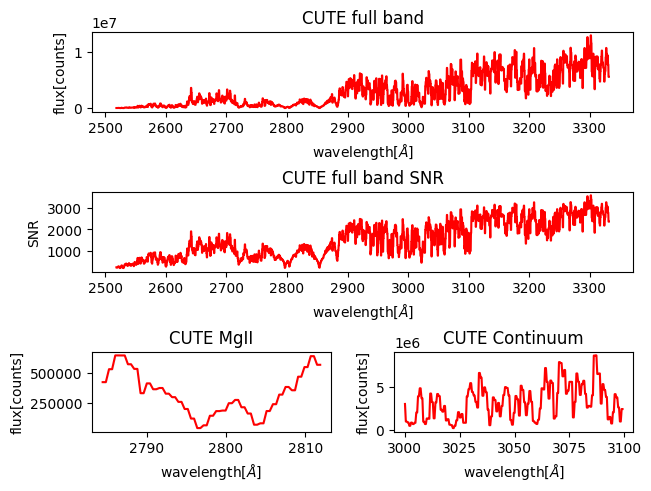

In [14]:
"""
Requires numpy, scipy, astropy, matplotlib
@author: A. G. Sreejith
"""
# import cute_snr_calculator as csc
import matplotlib.pyplot as plt
import numpy as np
import os

newdict = {}
newdict['s_dist']= 273.8097 
newdict['t_star'] = 5344  # Stellar Temperature in K (required)
newdict['r_star'] = 0.793   # Stellar Radius in R sun ()
newdict['m_star'] = 0.783   # Stellar V magnitude ()         
"""newdict['s_dist'] = 0.001 # Stellar parallax in milli arc second"""        
newdict['Ra'] = 26.0167    # RA in degrees       
newdict['Dec'] = -15.9375     # Dec in degrees       
newdict['fwhm'] = 0.05    # CUTE wavelength resolution in Amstron       
newdict['r_noise'] = 3.6   # Readout noise in e-/pix
newdict['dark_noise'] = 0.012  # Dark noise in e-/pix/s        
newdict['exptime'] = 300       # Exposure time in seconds
newdict['G'] = 1.0             # Gain of the CCD
newdict['width']= 10           # Spectrum width for extraction in pixels
newdict['line_core_emission'] = 1 # Set to one to add MgII lien core emission
newdict['mg2_col'] = None      # MgII column density (will be calculated if set to None)
newdict['mg1_col'] = None      # MgI column density (will be calculated if set to None)
newdict['fe2_col'] = None      # FeII column density (will be calculated if set to None)
newdict['add_ism_abs'] = 1     # Set to one to add ISM absorption
newdict['transit_duration'] = 162 # Set to one to add ISM absorption
newdict['readtime'] = 20         # CCD read time in seconds
newdict['number_of_transits'] = 15   # Number of transits observed
newdict['spectral_type'] = 'G8.5 V'    # Stellar spectral type
newdict['logr'] = 0.27              # Stellar activity parameter (Log R'HK)
# A0V is not defined so how is it taking it into account
    
ud=np.array(([2800,2900],[2850,2950]))
# user defined wavelength region

fig,snr_txt= cute_snr_calculator(newdict)

filename='cute_snr_'
imagefile=filename+'.png'
txtfile=filename+'.txt'
plt.savefig(os.path.join(os.path.curdir,imagefile),dpi=100)
file_out = os.path.join(os.path.curdir,'static',txtfile)
cute_snr = open(file_out,'w')
cute_snr.write(snr_txt)
cute_snr.close()


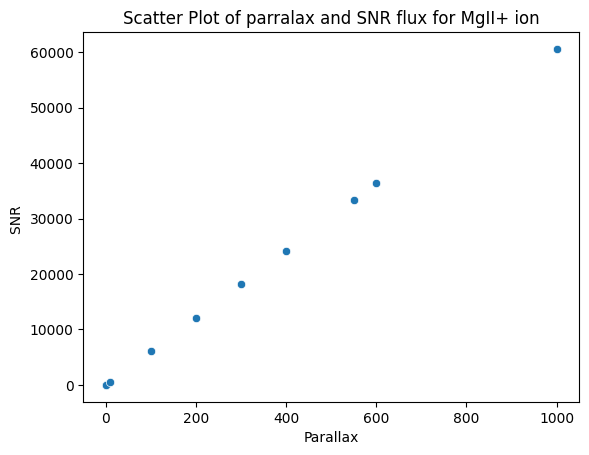

In [15]:
star_distance = [0.1,1,10,100,200,300,400,550,600,1000]
MgII= [0.4587,35.8517, 587.1838	,6060.3039,12121.2323, 18182.022,24242.7769,33333.8857,36364.2521,60607.1609]
import seaborn as sns 
sns.scatterplot(x=star_distance , y=MgII)

# Optionally, customize the plot
plt.title('Scatter Plot of parralax and SNR flux for MgII+ ion')
plt.xlabel('Parallax')
plt.ylabel('SNR ')
plt.show()

In [16]:

"""area=[]
dict={}
f = open("eff_area.txt", "w+")
for i in range (2500,3000,1):
    affective_area= (1.0006)*i/(i+1)*0.64*3.14*2500
    area.append(affective_area)
    dict[i]= affective_area
    print(i,end=' ')
    print(i,end=' ')
    print(i,end=' ')
    print(i,end=' ')
    print(dict[i],' ')"""
  



    



'area=[]\ndict={}\nf = open("eff_area.txt", "w+")\nfor i in range (2500,3000,1):\n    affective_area= (1.0006)*i/(i+1)*0.64*3.14*2500\n    area.append(affective_area)\n    dict[i]= affective_area\n    print(i,end=\' \')\n    print(i,end=\' \')\n    print(i,end=\' \')\n    print(i,end=\' \')\n    print(dict[i],\' \')'

 ccd_count[i]  = (ccd_count1[int(i/2)]/2)*exptime*G # assuming 2 resolution element
        noise[i]      = np.sqrt(ccd_count[i]+(width*(r_noise**2+(dark_noise*exptime*G))))
        snr[i]        = ccd_count[i]/noise[i]
????